## Imports and Helper Functions

In [9]:
import os
import glob
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sounddevice as sd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from keras.models import load_model

## **1 System Configuration**

In [10]:
import warnings
warnings.filterwarnings("ignore") # Filters out warnings when running notebook cells

In [11]:
import sys

# Adds this notebooks current directory to project path
# This is necessary due to issues with calling functions from src.utils
project_path = os.path.abspath('.')
if project_path not in sys.path:
    sys.path.append(project_path) 

In [12]:
# Check if current run is using GPU or not
gpu_devices = tf.config.list_physical_devices('GPU')
if len(gpu_devices) > 0:
    print('Using GPU')
else:
    print('Not Using GPU')

Using GPU


In [13]:
print(tf.__version__)

2.17.0


## **2 Import Dataset**

#### Emotion mapping: convert emotion code (string) to integer label (0-based)

In [14]:
# Determines path to each class folder
dataset_path = os.path.join(project_path, 'dataset')

instrument_labels = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

print(f'Number of classes: {len(instrument_labels)}')
print(instrument_labels)

Number of classes: 28
['flute', 'Trumpet', 'Clarinet', 'Tambourine', 'Acoustic_Guitar', 'Keyboard', 'Cymbals', 'vibraphone', 'Trombone', 'Saxophone', 'Ukulele', 'Violin', 'Dobro', 'Accordion', 'Harmonium', 'Floor_Tom', 'Piano', 'Mandolin', 'Harmonica', 'cowbell', 'Drum_set', 'Shakers', 'Electro_Guitar', 'Horn', 'Hi_Hats', 'Banjo', 'Organ', 'Bass_Guitar']


In [15]:
instrument_map = {instrument_name: index for index , instrument_name in enumerate(instrument_labels)}
print(instrument_map)

{'flute': 0, 'Trumpet': 1, 'Clarinet': 2, 'Tambourine': 3, 'Acoustic_Guitar': 4, 'Keyboard': 5, 'Cymbals': 6, 'vibraphone': 7, 'Trombone': 8, 'Saxophone': 9, 'Ukulele': 10, 'Violin': 11, 'Dobro': 12, 'Accordion': 13, 'Harmonium': 14, 'Floor_Tom': 15, 'Piano': 16, 'Mandolin': 17, 'Harmonica': 18, 'cowbell': 19, 'Drum_set': 20, 'Shakers': 21, 'Electro_Guitar': 22, 'Horn': 23, 'Hi_Hats': 24, 'Banjo': 25, 'Organ': 26, 'Bass_Guitar': 27}


#### Function to extract statistical MFCC features (for Random Forest)

In [16]:
def extract_statistical_features(file_path, n_mfcc=13):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        delta_mean = np.mean(mfcc_delta, axis=1)
        delta_std = np.std(mfcc_delta, axis=1)
        delta2_mean = np.mean(mfcc_delta2, axis=1)
        delta2_std = np.std(mfcc_delta2, axis=1)
        features = np.concatenate([mfcc_mean, mfcc_std, delta_mean, delta_std, delta2_mean, delta2_std])
        return features, y, sr, mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None, None, None

#### Function to extract fixed-size MFCC image for CNN

In [17]:
def get_mfcc_image(file_path, n_mfcc=13, max_len=216):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # Pad or truncate the MFCC to have a fixed number of frames (max_len)
        mfcc_fixed = librosa.util.fix_length(mfcc, size=max_len, axis=1)
        return mfcc_fixed
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

## Load Dataset and Extract Features

#### Define dataset path and recursively get all .wav files from the dataset

In [18]:
audio_files = glob.glob(os.path.join(project_path, 'dataset', '**', '*.wav'), recursive=True)

assert len(audio_files) > 0, "Audio files not found"

print("Number of audio files found:", len(audio_files))


Number of audio files found: 42311


#### Initialize lists for features and labels

In [19]:
features_list = []
labels_list = []
waveforms = []   # For visualization
sample_rates = []  # For visualization
mfccs = []       # For visualization
file_names = []  # To store file paths

# For CNN images
cnn_images = []


#### Process each audio file

In [20]:
file_path = audio_files[0]
dir_path = os.path.dirname(file_path)
dir_name = os.path.basename(dir_path)
print(dir_name)

flute


In [21]:
for file_path in audio_files:
    # Extract statistical features for Random Forest
    features, y, sr, mfcc = extract_statistical_features(file_path, n_mfcc=13)
    if features is not None:
        features_list.append(features)
        waveforms.append(y)
        sample_rates.append(sr)
        mfccs.append(mfcc)
        file_names.append(file_path)
        
        # Parse the filename
        dir_path = os.path.dirname(file_path)
        dir_name = os.path.basename(dir_path)
        print(dir_name)
        labels_list.append(dir_name)
        
        # Extract MFCC image for CNN classifier
        mfcc_img = get_mfcc_image(file_path, n_mfcc=13, max_len=216)
        if mfcc_img is not None:
            cnn_images.append(mfcc_img)

flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flute
flut

#### Convert lists to numpy arrays

In [22]:
features_array = np.array(features_list)
labels_array = np.array(labels_list)
cnn_images = np.array(cnn_images)

print("Features array shape (Random Forest):", features_array.shape)
print("Labels array shape:", labels_array.shape)
print("CNN images shape:", cnn_images.shape)  # Expected shape: (num_samples, 13, 216)

Features array shape (Random Forest): (42311, 78)
Labels array shape: (42311,)
CNN images shape: (42311, 13, 216)


## Visualize an Example Audio File and its MFCC Heatmap

#### Plot the audio waveform

In [23]:
# CODE
example_index = 0
y_example = waveforms[example_index]
sr_example = sample_rates[example_index]
mfcc_example = mfccs[example_index]

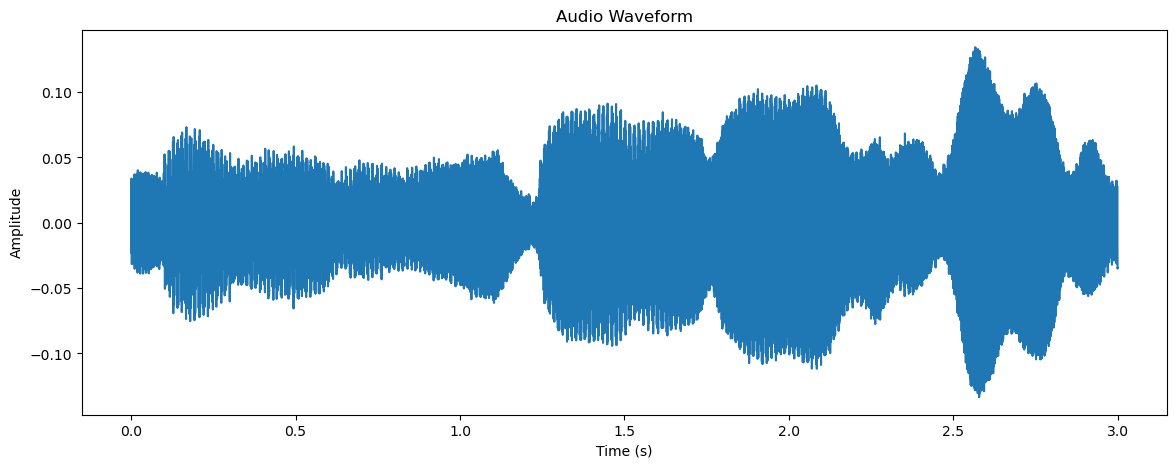

In [24]:
# CODE
# Create a time vector in seconds
t = np.linspace(0, len(y_example) / sr_example, num=len(y_example))

plt.figure(figsize=(14, 5))
plt.plot(t, y_example)
plt.title("Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

#### Plot the MFCC heatmap using imshow (as an alternative to specshow)

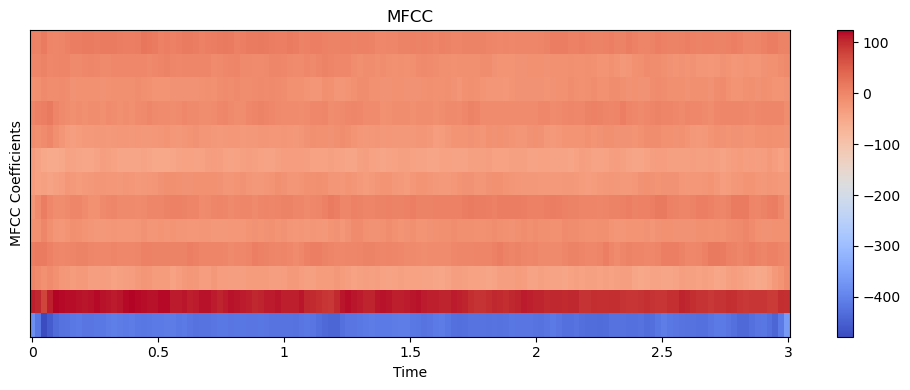

In [25]:
# CODE
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_example, x_axis='time')
plt.colorbar()
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.tight_layout()
plt.show()

## Random Forest classifier

#### Train-Test Split

In [26]:
# CODE
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.2, random_state=42, stratify=labels_array)

#### Train a Random Forest classifier

In [27]:
# CODE
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### Evaluate on the test set

In [28]:
# CODE
y_pred_rf = rf_clf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Classification Report:
                 precision    recall  f1-score   support

      Accordion       0.90      0.99      0.95       716
Acoustic_Guitar       0.93      0.99      0.96       731
          Banjo       0.97      0.98      0.98       600
    Bass_Guitar       1.00      1.00      1.00       723
       Clarinet       0.99      0.94      0.97       127
        Cymbals       1.00      0.56      0.72        41
          Dobro       0.98      0.61      0.75        97
       Drum_set       1.00      1.00      1.00       730
 Electro_Guitar       0.98      0.93      0.95       263
      Floor_Tom       0.89      0.96      0.92        81
      Harmonica       1.00      0.88      0.94        26
      Harmonium       1.00      1.00      1.00       263
        Hi_Hats       0.90      0.97      0.93        89
           Horn       1.00      1.00      1.00       252
       Keyboard       1.00      1.00      1.00       408
       Mandolin       0.96      0.93      0.95    

#### Plot the confusion matrix

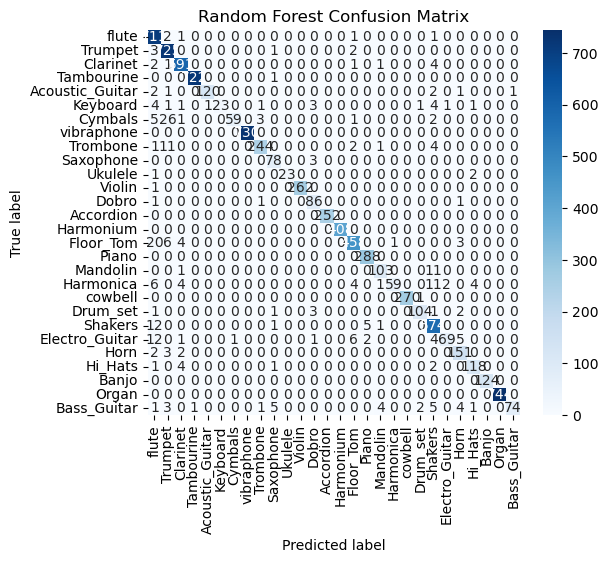

In [29]:
# CODE
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=instrument_labels, yticklabels=instrument_labels)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [30]:
# Create models directory if it doesn't exist
models_dir = os.path.join(project_path, 'models')
os.makedirs(models_dir, exist_ok=True)

# Save the rf model
joblib.dump(rf_clf, os.path.join(project_path, 'models/random_forest_model.pkl'))

['/home/gukardm/Course/med-analytics/Music-Final-Project/models/random_forest_model.pkl']

## Prepare Data and Train the CNN Classifier

#### Expand dimensions of CNN images to add a channel dimension (required by CNNs)

In [31]:
# cnn_images_exp = cnn_images[..., np.newaxis]  # New shape: (num_samples, 13, 216, 1)
cnn_images_exp = np.expand_dims(cnn_images, axis=-1)
assert len(cnn_images.shape) == 3, "dimension error?"

print(cnn_images_exp.shape)

(42311, 13, 216, 1)


#### Split data for the CNN classifier

In [32]:
print(instrument_map)

{'flute': 0, 'Trumpet': 1, 'Clarinet': 2, 'Tambourine': 3, 'Acoustic_Guitar': 4, 'Keyboard': 5, 'Cymbals': 6, 'vibraphone': 7, 'Trombone': 8, 'Saxophone': 9, 'Ukulele': 10, 'Violin': 11, 'Dobro': 12, 'Accordion': 13, 'Harmonium': 14, 'Floor_Tom': 15, 'Piano': 16, 'Mandolin': 17, 'Harmonica': 18, 'cowbell': 19, 'Drum_set': 20, 'Shakers': 21, 'Electro_Guitar': 22, 'Horn': 23, 'Hi_Hats': 24, 'Banjo': 25, 'Organ': 26, 'Bass_Guitar': 27}


In [33]:
num_label = [instrument_map.get(instrument) for instrument in labels_array]

In [43]:
idx = 20000
print(num_label[idx])
print(labels_array[idx])


13
Accordion


In [44]:
# CODE
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(cnn_images_exp, num_label, test_size=0.2, random_state=42, stratify=num_label)

In [45]:
print(len(instrument_labels))

28


In [46]:
import tensorflow as tf

y_train_cnn = tf.one_hot(y_train_cnn, len(instrument_labels))
y_test_cnn = tf.one_hot(y_test_cnn, len(instrument_labels))

I0000 00:00:1745467067.680104    6272 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745467067.680489    6272 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745467067.680691    6272 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745467067.758617    6272 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

#### Build the CNN model for multi-class classification

In [67]:
input_shape = X_train_cnn[0].shape
num_classes = len(instrument_labels)
print(f'input shape:{input_shape}\nnumber of classes:{num_classes}')

input shape:(13, 216, 1)
number of classes:28


In [70]:
from src.model import get_model

model = get_model(input_shape=input_shape, num_classes=num_classes, print_summary=True)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 11, 214, 128)   │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 11, 214, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 9, 212, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 9, 212, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 210, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 7, 210, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 5, 208, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 5, 208, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 3, 206, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 3, 206, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 158208)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │    81,003,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,212,828 (317.43 MB)

 Trainable params: 83,210,524 (317.42 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [72]:
# CODE
from keras.callbacks import EarlyStopping, ModelCheckpoint
callback = EarlyStopping(monitor='val_loss', patience=10)

# Save the epoch with the lowest loss
checkpoint = ModelCheckpoint(os.path.join(project_path, 'models/model.keras'), monitor='val_loss', save_best_only=True, mode='min', verbose=1)

#### Compile the model

In [74]:
# CODE
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy']),

(None,)

#### Train the CNN model

In [75]:
# CODE
history = model.fit(X_train_cnn, y_train_cnn, epochs=100, batch_size=16, validation_split=0.2, callbacks=[callback, checkpoint])

Epoch 1/100


I0000 00:00:1745467388.030304    9112 service.cc:146] XLA service 0x74e89c008650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745467388.030328    9112 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-04-24 00:03:08.119011: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-24 00:03:08.442048: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-04-24 00:03:09.938332: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1650', 8 bytes spill stores, 8 bytes spill loads

2025-04-24 00:03:13.344757: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.17GiB with fre

   3/1693 ━━━━━━━━━━━━━━━━━━━━ 1:10 42ms/step - categorical_accuracy: 0.0729 - loss: 29.8863 

I0000 00:00:1745467397.002563    9112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1691/1693 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.5906 - loss: 5.6431

2025-04-24 00:04:22.180318: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1650', 8 bytes spill stores, 8 bytes spill loads

2025-04-24 00:04:24.549444: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-24 00:04:24.944381: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1693/1693 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.5907 - loss: 5.6389

2025-04-24 00:04:33.571936: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_173', 8 bytes spill stores, 8 bytes spill loads




Epoch 1: val_loss improved from inf to 0.45925, saving model to /home/gukardm/Course/med-analytics/Music-Final-Project/models/model.keras
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 92s 48ms/step - categorical_accuracy: 0.5908 - loss: 5.6368 - val_categorical_accuracy: 0.8581 - val_loss: 0.4593
Epoch 2/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.8400 - loss: 0.5412
Epoch 2: val_loss improved from 0.45925 to 0.41705, saving model to /home/gukardm/Course/med-analytics/Music-Final-Project/models/model.keras
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 72s 43ms/step - categorical_accuracy: 0.8401 - loss: 0.5412 - val_categorical_accuracy: 0.8799 - val_loss: 0.4170
Epoch 3/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.8785 - loss: 0.4129
Epoch 3: val_loss did not improve from 0.41705
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 67s 40ms/step - categorical_accuracy: 0.8785 - loss: 0.4129 - val_categorical_accuracy: 0.8737 - val_loss: 0.4494
Epoch 4/100
1691/1693 ━━━━━━━━━━━

#### Evaluate the CNN model on the test set

In [76]:
# CODE
cnn_eval = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print("CNN Test Loss: {:.4f}, Test Accuracy: {:.4f}".format(cnn_eval[0], cnn_eval[1]))

2025-04-24 00:30:08.939735: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_173', 8 bytes spill stores, 8 bytes spill loads



CNN Test Loss: 0.3448, Test Accuracy: 0.9378


In [77]:
from src.utils import plot_results

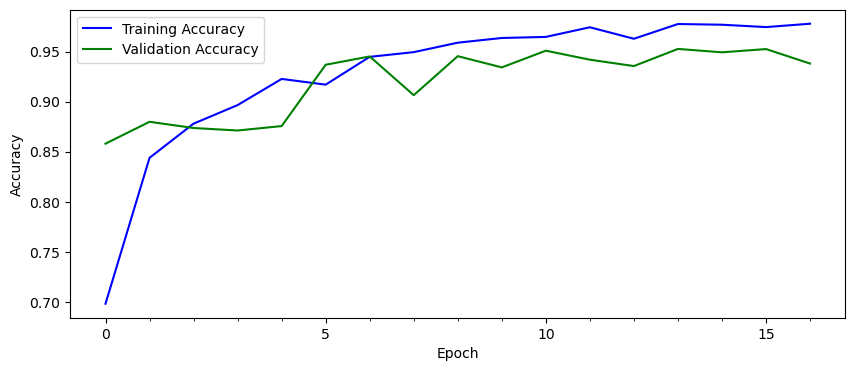

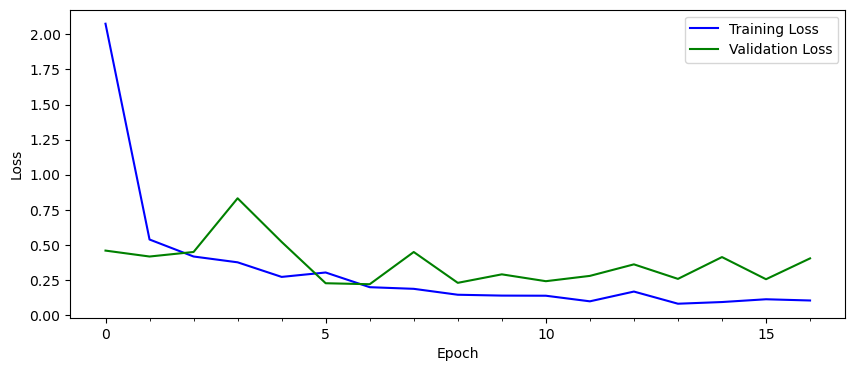

In [78]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["categorical_accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_categorical_accuracy"]
    
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["b", "g"])

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            metric_name=["Training Loss", "Validation Loss"],
            color=["b", "g"]);

## Save the Trained Models

In [ ]:
# CODE
# cnn_model.save('models/cnn_model.keras') Dont need to do this as we already saved the best model

## Load the saved models

In [79]:
# CODE
loaded_cnn_model = load_model(os.path.join(project_path, 'models/model.keras'))

## Inference on a New Audio File or via Microphone Recording

In [80]:
# Set source = 'file' to use an external audio file (e.g., 'new_audio.wav')
# Set source = 'mic' to record audio from the microphone

source = 'mic'  # Change to 'file' if you want to use an external file

if source == 'file':
    # Inference using an external audio file
    new_audio_path = 'new_audio.wav'  # Provide the path to your audio file
    
    # Extract features for the Random Forest model
    features_new, y_new, sr_new, mfcc_new = extract_statistical_features(new_audio_path, n_mfcc=13)
    if features_new is not None:
        features_new = features_new.reshape(1, -1)
    
    # Extract MFCC image for the CNN model
    mfcc_img_new = get_mfcc_image(new_audio_path, n_mfcc=13, max_len=216)
    if mfcc_img_new is not None:
        mfcc_img_new = mfcc_img_new[np.newaxis, ..., np.newaxis]

elif source == 'mic':
    duration = 3  # seconds to record
    fs = 48000   # Sampling rate
    print(f"Recording audio for {duration} seconds...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
    sd.wait() 
    y_new = recording.flatten()  
    sr_new = fs
    print("Recording complete.")

    mfcc_record = librosa.feature.mfcc(y=y_new, sr=sr_new, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc_record)
    mfcc_delta2 = librosa.feature.delta(mfcc_record, order=2)
    mfcc_mean = np.mean(mfcc_record, axis=1)
    mfcc_std = np.std(mfcc_record, axis=1)
    delta_mean = np.mean(mfcc_delta, axis=1)
    delta_std = np.std(mfcc_delta, axis=1)
    delta2_mean = np.mean(mfcc_delta2, axis=1)
    delta2_std = np.std(mfcc_delta2, axis=1)
    
    # Concatenate statistical features for Random Forest prediction
    features_new = np.concatenate([mfcc_mean, mfcc_std, delta_mean, delta_std, delta2_mean, delta2_std]).reshape(1, -1)

    
    # For the CNN model, create a fixed-size MFCC image
    max_len = 216
    mfcc_img_new = librosa.util.fix_length(mfcc_record, size=max_len, axis=1)
    mfcc_img_new = mfcc_img_new[np.newaxis, ..., np.newaxis]
else:
    raise ValueError("Invalid source selected. Please set source to 'file' or 'mic'.")

Recording audio for 3 seconds...
Recording complete.


#### Make predictions using the trained models

In [ ]:
rf_pred_new = rf_clf.predict(features_new)[0]
cnn_pred_probs_new = model.predict(mfcc_img_new)[0]
cnn_pred_new = np.argmax(cnn_pred_probs_new)

print("Random Forest Prediction:", instrument_labels[rf_pred_new])
print("CNN Prediction:", instrument_labels[cnn_pred_new])

## Compile a report detailing your challenges faced, and the performance of the sentiment analysis.

Your report Here

I was able to achieve a categorical_accuracy > 90% and test accuracy > 75%. Something I noticed between the two methods (random_forest vs cnn) was the time it took to train. The rf was significantly faster than the CNN. The CNN did perform much better when it came to recorded audio performance. Something else I attempted was to test the difference between sparse and one-hot encoeded labels. It seems like they performed similarly, although the loss and accuracy curve was smother for the spare. Im not sure if that was a coincidence or not. Some room for improvements could possibly be made in the model architecture, I still had room to experiment with the hidden layers. Finally I think there could be greater improvements in test accuracy if the dataset was bigger.